# Ingredient exploration:  quantiative fields 

We've cleaned the qualitative fields in the beer recipe data: the names of fermentables, hops, yeast and misc.

Let's get quantitative. Here we explore the distribution of values for different quantiative columns: recipe sizes and ingredient quantities. What we care most about is that the **scaled ingredient quantites** make sense. We'll figure out how to reject or fix the ones that don't.

_(Note: This notebook loads the entire dataset, so it requires *a lot* of memory (8+ GB).)_

* [First look: core](#core_first)
    * [Efficiency](#efficiency)
    * [Boil time](#boil_time)
    * [Batch size](#batch_size)
        * [Detour: Sam Corbeil](#corbeil)
        * [Ratio of batch to boil size](#batch_to_boil)
        
        
* [First look: ingredients](#ing_first)


**Scaled ingredient quantities**
* [Reasonable bounds for scaled ingredient quantities](#reasonable)
* [Distribution of malt additions](#malt_dist)
    * [Extreme values](#malt_dist_ext)
* [Distribution of hop additions](#hop_dist)
    * [Extreme values](#hop_dist_ext)


* [Ingredient units](#ing_units)


* [Deep dive: weird recipes](#weird)

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.rcParams['figure.figsize'] = [12, 6]

<a id="core_first"></a>
## First look: core
Let's look at the numbers available in the "core" DataFrame. These have to do with the size of the batch and brewing equipment.

In [8]:
store = pd.HDFStore("../data/all_recipes.h5","r")

In [9]:
core = store.get("core")

In [6]:
core.head()

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,
0,20.819765,24.983718,60.0,pope,0.75,boo,recipes/boo.xml,20a,bjcp,fruit beer,1.0
1,18.927059,23.658824,60.0,casey witherow,0.80,pumpkin ale 2012,recipes/pumpkin-ale-2012-3.xml,23a,bjcp,specialty beer,1.0
2,22.712471,28.390588,60.0,leonardgrimes,0.75,hoppy ale 19 legacy,recipes/hoppy-ale-19-legacy.xml,23a,bjcp,specialty beer,1.0
3,20.819765,26.043633,60.0,beefcake,0.80,cherry wheat,recipes/cherry-wheat-10.xml,23a,bjcp,specialty beer,1.0
4,20.819765,24.983718,60.0,dukeredhair,0.75,bright and bitter (just like my men) 4,recipes/bright-and-bitter-just-like-my-men-4.xml,14b,bjcp,american ipa,1.0


The quantitative features are: batch_size, boil_size, boil_time, and efficiency. Let's inspect them one by one.

In [7]:
cols = ["batch_size", "boil_size", "boil_time", "efficiency"]

In [8]:
core[cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

,batch_size,boil_size,boil_time,efficiency
count,330790.000000,330790.000000,330790.000000,330786.000000
mean,32.982284,33.567950,64.158034,0.731820
std,185.620543,182.689716,174.567092,0.068315
min,0.200000,-227.011144,0.000000,0.000000
1%,3.785412,3.320000,30.000000,0.375000
5%,9.463529,6.336000,60.000000,0.620000
25%,18.927059,22.712471,60.000000,0.750000
50%,19.684141,23.658824,60.000000,0.750000
75%,21.955388,27.027840,60.000000,0.750000
95%,45.424941,54.093534,90.000000,0.800000


<a id='efficiency'></a>
### Efficiency
Easiest one first! 
Please always be a number from 0 to 1.

In [189]:
qty = 'efficiency'

#### Nulls

In [194]:
# What recipes have null?
core[core[qty].isna()]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,
35571,20.819765,26.876424,60.0,mroh,NaN,gotta go,recipes/gotta-go-1.xml,16c,bjcp,saison,1.0
52247,9.463529,5.110306,60.0,cpaumi,NaN,chris's wicked wit #1,recipes/chriss-wicked-wit-1.xml,16a,bjcp,witbier,1.0
67858,20.819765,25.551530,60.0,david stelting,NaN,easy cream,recipes/easy-cream-1.xml,6a,bjcp,cream ale,1.0
295107,66.244706,70.825054,60.0,omokoro,NaN,white ipa,recipes/white-ipa-145.xml,14b,bjcp,american ipa,1.0


These look otherwise fine. I'm cool with setting these to the most common value, 75%.

#### Distribution

In [196]:
qty_values = core[qty].dropna()

In [217]:
# Set reasonable values
bounds = [0.3, 1]

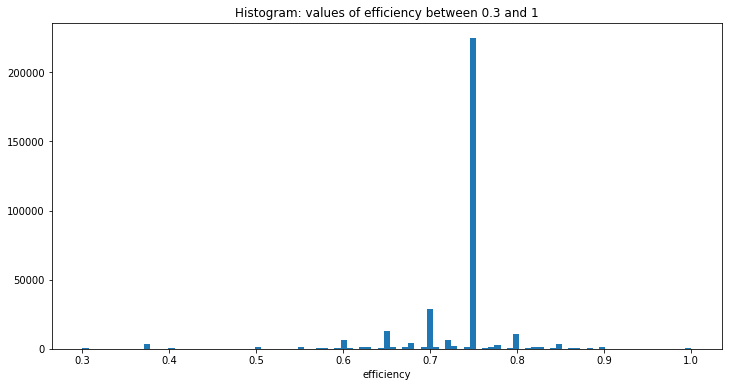

In [218]:
# Show a histogram
# Use both underflow and overflow bins
bins = np.linspace(bounds[0], bounds[1], 100)
plt.hist(np.clip(qty_values, bins[0], bins[-1]), bins=bins)
plt.title('Histogram: values of {} between {} and {}'.format(qty, bounds[0], bounds[1]))
plt.xlabel(qty);

Not a lot of overflow here! That's good. Looks like most are handy rounded numbers: 60, 65, 70, 75, 80, 85%.

#### Unphysical and unreasonable values

In [219]:
# What fraction are good?
qty_values[qty_values.between(*bounds)].count()/qty_values.count() 

0.9991051616452933

In [220]:
# How many are high?
qty_values[qty_values > max(bounds)].count()

27

In [221]:
# What recipes are high?
core[core[qty] > max(bounds)]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,
21541,7.570824,9.084988,60.0,supermutant brewmaster,1.3500,ryepa,recipes/ryepa-122.xml,19c,bjcp,american barleywine,1.0
23304,9.463529,11.356235,60.0,supermutant brewmaster,1.2500,"""finnish"" stout",recipes/finnish-stout.xml,13e,bjcp,american stout,1.0
23561,50.000000,14.210000,60.0,tal gill,2.8391,hop chakra,recipes/hop-chakra.xml,14c,bjcp,imperial ipa,1.0
27047,25.000000,7.920000,60.0,thorup,2.8391,ginger?,recipes/ginger-8.xml,23a,bjcp,specialty beer,1.0
37384,9.463529,11.356235,60.0,supermutant brewmaster,1.2500,luck of the irish stout,recipes/luck-of-the-irish-stout.xml,13e,bjcp,american stout,1.0
43929,14.006024,12.491859,60.0,anonymous,1.1600,borealis (a),recipes/borealis-a.xml,23a,bjcp,specialty beer,1.0
61104,27.000000,8.556000,60.0,cja,2.8391,california pale ale,recipes/california-pale-ale-10.xml,10a,bjcp,american pale ale,1.0
65302,26.000000,7.900500,45.0,gareth lyons,2.8391,gars red ale (smithwicks),recipes/gars-red-ale-smithwicks.xml,9d,bjcp,irish red ale,1.0
84715,34.000000,10.776000,60.0,steve,2.8500,steve's cascade witbier 2014,recipes/steves-cascade-witbier-2014.xml,16a,bjcp,witbier,1.0


Like with the nulls, I'm OK giving these the median value, 75%. 

In [222]:
# How many are low?
qty_values[qty_values < min(bounds)].count()

269

In [223]:
# What recipes are low?
core[core[qty] < min(bounds)]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,
177,24.605177,30.775398,60.0,van der dans brewery,0.2500,evil wheat,recipes/evil-wheat.xml,15b,bjcp,dunkelweizen,1.0
523,18.927059,23.658824,60.0,phil a.,0.0000,notting hill pub bitter,recipes/notting-hill-pub-bitter.xml,8a,bjcp,standard/ordinary bitter,1.0
872,18.927059,17.034353,60.0,djkpgh,0.0000,extract amber #2,recipes/extract-amber-2.xml,10b,bjcp,american amber ale,1.0
4507,20.819765,23.848094,60.0,josh reed,0.0000,molasses graff,recipes/molasses-graff.xml,10b,bjcp,american amber ale,1.0
4741,22.000000,6.910000,60.0,greenwilly,0.0000,not harper's canadian,recipes/not-harpers-canadian.xml,10a,bjcp,american pale ale,1.0
5414,18.927059,13.248941,60.0,phil a.,0.0000,malibu brown ale,recipes/malibu-brown-ale.xml,10c,bjcp,american brown ale,1.0
6067,18.927059,17.034353,60.0,djkpgh,0.0000,extract amber,recipes/extract-amber-d59065.xml,10b,bjcp,american amber ale,1.0
6757,18.927059,22.333930,60.0,bright tank brewing,0.0100,jay's hofbrau clone v1.5,recipes/jay-s-hofbrau-clone-v1-5.xml,1d,bjcp,munich helles,1.0
6944,50.000000,16.182250,90.0,katjelam,0.2500,#15004 burton table beer,recipes/15004-burton-table-beer.xml,8a,bjcp,standard/ordinary bitter,1.0


These look like mistakes to me. These most aren't extreme beers that would warrant a low efficiency. I would say to just assign them the median value.

<a id='boil_time'></a>
### Boil time
The next easiest one.
Please always be a number from 0 to 120.

In [224]:
qty = 'boil_time'

#### Nulls

In [225]:
# What recipes have null?
core[core[qty].isna()]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,


F YEAH.

#### Distribution

In [226]:
qty_values = core[qty].dropna()

In [234]:
# Set reasonable values
bounds = [20, 120]

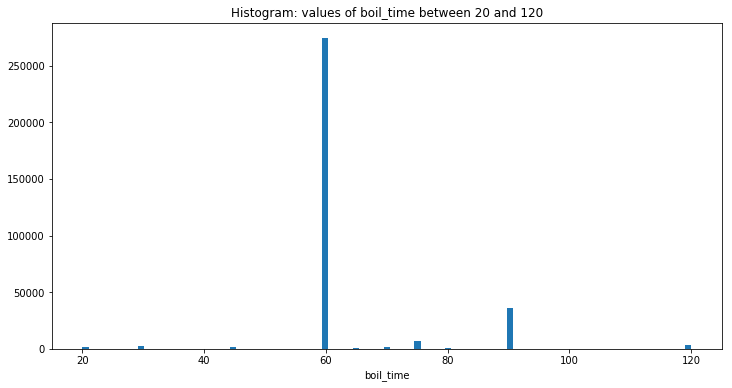

In [235]:
# Show a histogram
# Use both underflow and overflow bins
bins = np.linspace(bounds[0], bounds[1], 100)
plt.hist(np.clip(qty_values, bins[0], bins[-1]), bins=bins)
plt.title('Histogram: values of {} between {} and {}'.format(qty, bounds[0], bounds[1]))
plt.xlabel(qty);

F yeah again. This is wonderful and exactly what we expect.

#### Unphysical and unreasonable values

In [236]:
# What fraction are good?
qty_values[qty_values.between(*bounds)].count()/qty_values.count() 

0.9934459929260255

In [237]:
# How many are high?
qty_values[qty_values > max(bounds)].count()

517

In [238]:
# What recipes are high?
core[core[qty] > max(bounds)]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,
417,17.791435,27.254965,150.0,sandboxbeer,0.680,oxford,recipes/oxford.xml,19b,bjcp,english barleywine,1.0
481,18.927059,56.781177,200.0,a k,0.750,high gravity ale,recipes/high-gravity-ale.xml,23a,bjcp,specialty beer,1.0
2360,17.034353,42.585883,180.0,mroh,0.690,reap,recipes/reap.xml,15c,bjcp,weizenbock,1.0
2369,9.463529,17.223624,135.0,hidden fish brewhouse,0.750,zythos pale,recipes/zythos-pale-1.xml,10a,bjcp,american pale ale,1.0
4053,30.283294,40.693177,150.0,matt lennon,0.750,smashing the barrel,recipes/smashing-the-barrel.xml,19c,bjcp,american barleywine,1.0
4369,23.015304,35.317892,150.0,herb tarlek,0.700,1871 carlsberg mild,recipes/1871-carlsberg-mild.xml,8c,bjcp,extra special/strong bitter (english pale ale),1.0
5709,20.819765,30.283294,150.0,aarongerman,0.750,snbf,recipes/snbf-ce0cf7.xml,19c,bjcp,american barleywine,1.0
6032,24.605177,41.639530,180.0,mrute,0.750,bcbs clone,recipes/bcbs-clone-5b882e.xml,13f,bjcp,russian imperial stout,1.0
7908,20.819765,45.803483,360.0,greg nelson,0.620,fifth element,recipes/fifth-element-f6a5b0.xml,19b,bjcp,english barleywine,1.0


Most of these look fine. It's not that crazy to boil certain styles 180+ minutes: this is traditional for barleywine, weizenbock, gueze, imperial stouts, old ales.

Which ones are truly too high? 5 hours seems like a lot.

In [241]:
core[core[qty] > 4*60]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,
7908,20.819765,45.803483,360.0,greg nelson,0.620,fifth element,recipes/fifth-element-f6a5b0.xml,19b,bjcp,english barleywine,1.0
17270,22.712471,-113.562353,360.0,brian keifer,0.750,tokillya barleywine,recipes/tokillya-barleywine.xml,22c,bjcp,wood-aged beer,1.0
21741,22.712471,-113.562353,360.0,paul,0.740,doomsday imperial porter,recipes/doomsday-imperial-porter.xml,22c,bjcp,wood-aged beer,1.0
30547,18.927059,21.046889,300.0,kredhead,0.750,lambic june 2013,recipes/lambic-june-2013.xml,17d,bjcp,straight (unblended) lambic,1.0
32620,17.500000,19.620000,300.0,nmh,0.780,2017 02 28 dipa wlp099,recipes/2017-02-28-dipa-wlp099.xml,14c,bjcp,imperial ipa,1.0
32987,20.819765,27.254965,6090.0,psychobrawler,0.730,oatmeal porter,recipes/oatmeal-porter-277723.xml,12b,bjcp,robust porter,1.0
40569,9.501384,-47.317647,360.0,brandon myers,0.700,old longboil,recipes/old-longboil.xml,19b,bjcp,english barleywine,1.0
42190,20.819765,43.721506,330.0,micah@froth.us,0.750,maple-bourbon old ale,recipes/maple-bourbon-old-ale.xml,13f,bjcp,russian imperial stout,1.0
84708,37.891972,567.811767,280.0,brian keifer,0.800,bipolar chocolate disorder,recipes/bipolar-chocolate-disorder.xml,21b,bjcp,christmas/winter specialty spiced beer,1.0


Again, I'm not mad at any of these! Most of these are traditionally long boiled styles. The freaky 400+ minute ones are kvass and vodka. I won't yuck someone else's yum. I say keep all of them.

**EXCEPT** the 99999 and 6000+ minute one. Screw you guys. 

In [276]:
# Reject these ones. 
core[core[qty] > 500]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,
32987,20.819765,27.254965,6090.0,psychobrawler,0.73,oatmeal porter,recipes/oatmeal-porter-277723.xml,12b,bjcp,robust porter,1.0
130337,18.927059,5.110306,602.0,adk,0.75,gilligan's crush,recipes/gilligan-s-crush.xml,21a,bjcp,"spice, herb, or vegetable beer",1.0
149253,4.921035,0.378541,99999.0,jason chalifour,0.75,center field cider (2012),recipes/center-field-cider-2012.xml,10b,bjcp,american amber ale,1.0


In [245]:
# How many are low?
qty_values[qty_values < min(bounds)].count()

1651

In [249]:
# What styles are low?
core[core[qty] < min(bounds)].style_name.value_counts()

berliner weisse                                   422
specialty beer                                    310
american pale ale                                 238
fruit beer                                        120
american ipa                                       98
spice, herb, or vegetable beer                     37
saison                                             34
american amber ale                                 33
weizen/weissbier                                   31
blonde ale                                         28
american wheat or rye beer                         23
standard/ordinary bitter                           20
belgian specialty ale                              17
mild                                               14
imperial ipa                                       13
witbier                                            11
lite american lager                                10
extra special/strong bitter (english pale ale)     10
wood-aged beer              

I'm okay with the berliners and specialty beers. They're often not boiled. Let's check out some of the others. 

In [271]:
no_boil_styles = ['berliner weisse', 'specialty beer', 'spice, herb, or vegetable beer', 
                  'fruit beer', 'straight (unblended) lambic']
normally_boiled_beers = core[(core[qty] < min(bounds)) & ~(core.style_name.isin(no_boil_styles))].index
core.loc[normally_boiled_beers]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,
253,15.141647,16.088000,15.0,nate,0.75,willamette smash,recipes/willamette-smash-ae3293.xml,8b,bjcp,special/best/premium bitter,1.0
471,0.709765,0.733424,10.0,utapia,0.75,prop-2,recipes/prop-2.xml,10a,bjcp,american pale ale,1.0
616,20.819765,21.450667,10.0,mike winer,0.65,sour imperial southern brownie v2.0,recipes/sour-imperial-southern-brownie-v2-0.xml,16e,bjcp,belgian specialty ale,1.0
729,8.000000,2.215500,15.0,lee haseley,0.75,motu_hamilton,recipes/motu-hamilton.xml,10a,bjcp,american pale ale,1.0
1538,18.927059,19.911266,15.0,schmitty kragen,0.75,blonde meg,recipes/blonde-meg.xml,6b,bjcp,blonde ale,1.0
1817,20.819765,26.497882,0.0,fred ochsenhirt,0.75,saison a l'orange,recipes/saison-a-lorange.xml,16c,bjcp,saison,1.0
1957,3.785412,3.898974,10.0,adamj,0.75,sima,recipes/sima-1.xml,14b,bjcp,american ipa,1.0
2829,20.819765,23.753459,15.0,grandpastefan,0.70,son of krapfen,recipes/son-of-krapfen.xml,16c,bjcp,saison,1.0
3013,18.927059,11.961901,15.0,jaysonwhelpley,0.75,spur of the moment ipa,recipes/spur-of-the-moment-ipa.xml,14a,bjcp,english ipa,1.0


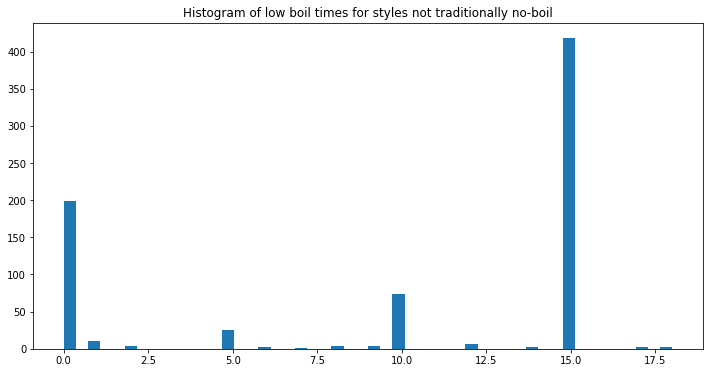

In [273]:
plt.hist(qty_values.loc[normally_boiled_beers], bins=50, stacked=True)
plt.title('Histogram of low boil times for styles not traditionally no-boil');

In [277]:
# OK, what about the completely unboiled ones?
no_boil_styles = ['berliner weisse', 'specialty beer', 'spice, herb, or vegetable beer', 
                  'fruit beer', 'straight (unblended) lambic']
weird_no_boiled_beers = core[(core[qty] == 0) & ~(core.style_name.isin(no_boil_styles))].index
core.loc[weird_no_boiled_beers]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,
1817,20.819765,26.497882,0.0,fred ochsenhirt,0.75,saison a l'orange,recipes/saison-a-lorange.xml,16c,bjcp,saison,1.0
3646,22.000000,5.810000,0.0,matthew,0.75,ww epa w willamette hops - experiment,recipes/ww-epa-w-willamette-hops-experiment.xml,8c,bjcp,extra special/strong bitter (english pale ale),1.0
5112,3.785412,3.406871,0.0,markyb,0.75,plale ale special batch,recipes/plale-ale-special-batch.xml,10a,bjcp,american pale ale,1.0
7385,17.034353,17.034353,0.0,ken cooper,0.60,raw sour wheat,recipes/raw-sour-wheat.xml,6d,bjcp,american wheat or rye beer,1.0
9098,23.000000,23.000000,0.0,matthew,0.75,william warn epa,recipes/william-warn-epa.xml,8c,bjcp,extra special/strong bitter (english pale ale),1.0
9620,23.000000,23.000000,0.0,matthew,0.75,mangrove jack's tyneside brown ale,recipes/mangrove-jacks-tyneside-brown-ale.xml,11c,bjcp,northern english brown ale,1.0
10688,16.000000,4.230000,0.0,balpar,0.75,"1st liquid, oktawia",recipes/1st-liquid-oktawia.xml,10a,bjcp,american pale ale,1.0
11297,6.813741,6.813741,0.0,xavalina,0.75,sourdough wheat,recipes/sourdough-wheat.xml,6d,bjcp,american wheat or rye beer,1.0
11425,21.000000,5.550000,0.0,jef,0.75,lemon grass wheat,recipes/lemon-grass-wheat-170851.xml,16a,bjcp,witbier,1.0


In [275]:
core.loc[weird_no_boiled_beers].style_name.value_counts()

american pale ale                                 42
american amber ale                                16
american ipa                                      15
saison                                            12
mild                                               8
weizen/weissbier                                   8
extra special/strong bitter (english pale ale)     7
wood-aged beer                                     6
irish red ale                                      6
blonde ale                                         6
american barleywine                                6
imperial ipa                                       5
lite american lager                                5
other smoked beer                                  4
premium american lager                             4
american wheat or rye beer                         4
belgian tripel                                     4
christmas/winter specialty spiced beer             3
sweet stout                                   

I'm inclined to set all of these to 60min. I think they're a mistake.

<a id='batch_size'></a>
### Batch size

What's up with those crazy maxima for batch size?

In [10]:
core.iloc[core["batch_size"].values.argmax()]

batch_size                        28000
boil_size                       8876.18
boil_time                            60
brewer                      sam corbeil
efficiency                         0.95
name                            project
recipe_file       recipes/project-1.xml
style_category                       2a
style_guide                        bjcp
style_name        german pilsner (pils)
style_version                         1
Name: 135918, dtype: object

Aha! Looks like a familiar face is leading the pack on brewtoad batch sizes.

<a id="corbeil"></a>
### Detour: Ontario craft beer's brewtoad icon, Sam Corbeil

Some interesting notes from Rob...

  * Sam Corbeil is [the brewmaster at Sawdust City](https://www.sawdustcitybrewing.com/team_member/sam-corbeil/) in Muskoka. It is apparently a well-known "secret" that he posts the brewery's recipes on brewtoad.
  * Boil size is typically the largest volume in your recipe since it is the volume of liquid you start with. Everything you do to your recipe after this decreases the amount of liquid you'll end up with.
      * Boiling will decrease liquid (usually about 10%/hour for home brew, ~5%/hr for commercial)
      * Cooling will decrease ~4%
      * Lose volume to [trub](https://en.wikipedia.org/wiki/Trub_(brewing)) as well (where solids separate from the liquid). This can vary from 2-10%.
      * Wort then goes into fermenter, where fermentation will steal volume, 5-30% (wow!)
      * A little bit of loss in [racking](https://en.wikipedia.org/wiki/Racking), which is transferring from fermenter to secondary fermenter (bright tank in commercial brewing). FYI, "bright" is a breweing term meaning "clear", indicating nothing else needs to happen to the beer before bottling/kegging.
      * Finally, can lose volume in the actual bottling/kegging process. Could be ~10% (higher in home brewing).
      * Note that the above percentages all refer to the volume from the previous step, not the original volume.
  * Batch size and boil size are usually very close for home brews. Batch size is meant to be the final kegged/bottled volume, but sometimes people treat it as the volume in the fermenter.
  * Sometimes, commercial recipes will have multiple boils go into one batch. In one case above, batch_size is ~3.2x the boil size, so it's likely that the batch actually includes 4 boils. We should make sure to properly consider this when normalizing quantities.

The takeaway from the above is that the boil size is pretty clear whereas the batch size can vary a lot, and even the interpretation varies since it can be bottled volume vs fermenter volume.

One way to identify problematic recipes might be to look at $\frac{batch\_size}{boil\_size}$

Let's check out some Sam Corbeil recipes. This could shed some lihgt on what the pros are up to.

In [26]:
core[(core["brewer"] == "sam corbeil")&(core["batch_size"] > 10000)]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version,vol_ratio
id,,,,,,,,,,,,
135918,28000.0,8876.1840,60.0,sam corbeil,0.95,project,recipes/project-1.xml,2a,bjcp,german pilsner (pils),1.0,3.154509
242591,25000.0,6769.4075,60.0,sam corbeil,0.98,golden norway,recipes/golden-norway.xml,10a,bjcp,american pale ale,1.0,3.693085


In [27]:
recipe = store.select("/ingredients", where="index == 135918")
recipe

,amount,attenuation,color,ferm_amount,ferm_display_amount,ferm_name,ferm_origin,ferm_scaled,ferm_yield,flocculation,...,misc_amount,misc_amount_is_weight,misc_name,misc_time,misc_use,potential,product_id,type,yeast_laboratory,yeast_name
id,,,,,,,,,,,,,,,,,,,,,
135918,NaN,77.5,2.0,3800.0,3800.0 kg,canada malting canadian 2-row,NaN,0.307379,0.755776,NaN,...,NaN,False,NaN,NaN,NaN,1.035,NaN,lager,white labs,american lager yeast
135918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Rob thinks the above recipes are actually real. There is a brewery called [Cool Brewery](https://www.coolbeer.com/) that does a lot of contract brewing. They have a large antique copper kettle that other breweries use for contract brewing. It's about 80 HL (hectoliters), which corresponds decently to the boil size in the above recipes. The fact that those are pils and pale ales means they would likely be produced in bigger batches as well. So, long story short, the normalized quanties could be reasonable provided the hop amount is relative to the boil size. More investigation needed...

<a id='batch_to_boil'></a>
### Back to the data: ratio of batch size to boil size
This could be a useful way to identify dirty/bad recipes.

In [28]:
core["vol_ratio"] = core["batch_size"] / core["boil_size"]

In [29]:
core["vol_ratio"].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

count    330790.000000
mean          0.942521
std          26.400761
min       -5000.000000
1%            0.598528
5%            0.700117
25%           0.799679
50%           0.800000
75%           0.833333
95%           3.134796
99%           3.443526
max         874.027778
Name: vol_ratio, dtype: float64

Why are there negative ratios? It looks like there are some negative boil sizes... what's up with those?

In [13]:
core[core["boil_size"] < 0]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version,vol_ratio
id,,,,,,,,,,,,
240,22.712471,-1.135624,60.0,robertmeyer6,0.650,saison 3711,recipes/saison-3711.xml,16c,bjcp,saison,1.0,-20.000000
5973,23.090000,-0.380000,60.0,antonio garofalo,0.750,ascipa 2 3 luppoli,recipes/ascipa-2-3-luppoli-1.xml,14b,bjcp,american ipa,1.0,-60.763158
9326,20.000000,-0.004000,60.0,sjkim/soma,0.700,ipa,recipes/ipa-822.xml,10a,bjcp,american pale ale,1.0,-5000.000000
17270,22.712471,-113.562353,360.0,brian keifer,0.750,tokillya barleywine,recipes/tokillya-barleywine.xml,22c,bjcp,wood-aged beer,1.0,-0.200000
21741,22.712471,-113.562353,360.0,paul,0.740,doomsday imperial porter,recipes/doomsday-imperial-porter.xml,22c,bjcp,wood-aged beer,1.0,-0.200000
31812,18.927059,-4.731765,60.0,cyrock1,0.750,muscat wit,recipes/muscat-wit.xml,23a,bjcp,specialty beer,1.0,-4.000000
38745,18.927059,-1.173478,60.0,sunporch brewery,0.750,brecksville double ipa,recipes/brecksville-double-ipa.xml,14c,bjcp,imperial ipa,1.0,-16.129032
40569,9.501384,-47.317647,360.0,brandon myers,0.700,old longboil,recipes/old-longboil.xml,19b,bjcp,english barleywine,1.0,-0.200800
51941,18.930000,-0.380000,60.0,antonio garofalo,0.720,foreign extra stout,recipes/foreign-extra-stout-17.xml,13d,bjcp,foreign extra stout,1.0,-49.815789


Some recipes have very high values of this ratio. How high?

In [24]:
high_ratio = core[core["vol_ratio"] > 1]["vol_ratio"].values

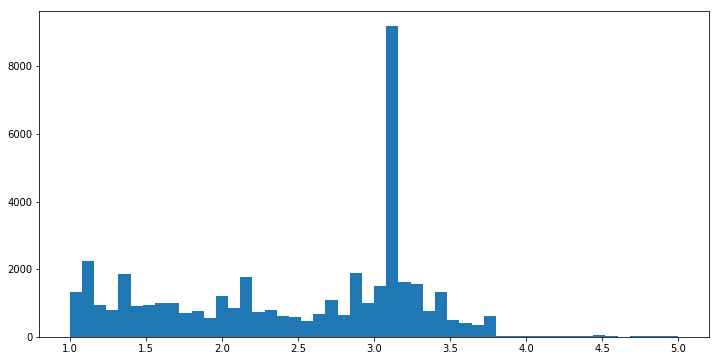

In [121]:
plt.hist(high_ratio, bins=50, range=[1,5]);

The above is a bit surprising. The peak near 3 seems reasonable given that breweries will often do 4 boils per batch. However, we would also expect similar peaks for 2, 3, 5, etc.

I guess we should make the assumption that anything near 1 is likely a mixup of boil and batch size, and anything above 2 can maybe be ceiling'd to the integer above for number of boils per batch...

<a id="ing_first"></a>
## First look: ingredients
Let's move on to numbers in the "ingredients" DataFrame. These have to do with the quantity of each ingredient in a recipe, as well as analytical parameters of those ingredients. (color, yield, alpha acids, etc).

In [10]:
ing_storer = store.get_storer("/ingredients")

In [11]:
ing_storer.non_index_axes

[(1,
  ['amount',
   'attenuation',
   'color',
   'ferm_amount',
   'ferm_display_amount',
   'ferm_name',
   'ferm_origin',
   'ferm_scaled',
   'ferm_yield',
   'flocculation',
   'form',
   'hop_alpha',
   'hop_amount',
   'hop_display_amount',
   'hop_form',
   'hop_name',
   'hop_origin',
   'hop_scaled',
   'hop_time',
   'misc_amount',
   'misc_amount_is_weight',
   'misc_name',
   'misc_time',
   'misc_use',
   'potential',
   'product_id',
   'type',
   'yeast_laboratory',
   'yeast_name'])]

The quantities we'll care most about are the scaled ones. They show the **proportion** of each ingredient in the recipe, which is the salient number you need to know about the ingredient if you're going to compare recipes, or make the beer on your own system.

What are our scaled quantities?

In [13]:
scaled_cols = [col for col in ing_storer.non_index_axes[0][1] if "scaled" in col] + [col for col in core.columns if "scaled" in col]
print("Scaled columns: ", scaled_cols)

Scaled columns:  ['ferm_scaled', 'hop_scaled']


Right now, it's just the two columns. We'll likely need to make `misc_scaled` as well. Interestingly, we don't need to worry about yeast since amount is rarely specified. Rob says this is because homebrew yeast is usually sold in a packet sized to a 5 Gal batch, so you only ever just use 1 or 2 packets. If it's a professional recipe, it would likely include _pitch rate_ - this is measured in millions of cells per ml. The rule of thumb is to add 5-15 million cells/ml/degree plato.

In [14]:
scaled = store.select("/ingredients", columns=scaled_cols)

In [15]:
scaled.head()

,ferm_scaled,hop_scaled
id,,
0,0.094164,0.000051
0,0.009703,0.000054
0,0.010879,NaN
0,0.004852,NaN
0,0.002499,NaN


If units are correct from the recipes, the scaled quantities should be in kg/L. What are reasonable values for fermentables and hops?

<a id='reasonable'></a>
## Reasonable bounds for scaled ingredient quantities

Let's remind ourselves the units, and define some constants so we can create some intuition.

In [2]:
# Units: 
#  Volume: L
#  Weight: kg (ferm), kg (hops)
#  Alpha: % as an integer
# Let's work with my intuition for a 20L boil size
batch_size = 20
# Let's set a factor to look wider than our "reasonable" estimates
fudge_factor = 2

First, malts.

In [3]:
# Reminder of the formula: 
# d["ferm_scaled"] = d["ferm_amount"] * d["ferm_yield"] * core_vals["efficiency"] / core_vals["boil_size"]
# Let's make basic assumptions about yield and efficiency
yield_typical = 0.75
eff_typical = 0.75

#  Min: a small recipe might have 3kg of malt (eg: a lite lager I made)
ferm_small = 3
#  Typical: a classic 5% ABV homebrew recipe will have about 4kg of malt (eg. a pilsner I made)
ferm_typical = 4
#  Max: a very beefy recipe might have a total of 10kg malt (eg. an imperial stout I made)
ferm_large = 10
# Apply the fudge factor to form very conservative expectations
ferm_range = [ferm_small/fudge_factor, ferm_typical, ferm_large*fudge_factor]

# Scale to typical yields and efficiencies
ferm_range = [i * yield_typical * eff_typical for i in ferm_range]

Now hops. 

In [4]:
# Reminder of the formula: 
# d["hop_scaled"] = (d["hop_amount"] * d["hop_alpha"] * (1 - 0.1 * is_leaf)) / core_vals["boil_size"]

#  Min: an addition of smaller than .25oz = 7g is silly. (eg. a sour I made)
hop_amount_small = 0.007
#      This hop could concievably have an alpha as low as 2%. 
hop_alpha_small = 0.02

#  Typical: a reasonable American Pale Ale might have 5oz = 150g of hops (eg. a Sierra Nevada clone from the internet)
hop_amount_typical = 0.150
#      Cascade has alpha around 8%
hop_alpha_typical = 0.08

# Max: a huge IPA might have 5lb/bbl of dry hops (eg. what breweries were making in 2017)
hop_lb_per_bbl_large = 5
hop_amount_large = hop_lb_per_bbl_large * (1/0.386) * 20 / 1000 # Convert lb/bbl to kg, using the conversion 0.386g/L per lb/bbl, and 20L
#       This hop could have an alpha as high as 20%.
hop_alpha_large = 0.20
# Form our range
hop_range = [hop_amount_small*hop_alpha_small/fudge_factor, 
             hop_amount_typical*hop_alpha_typical,
             hop_amount_large*hop_alpha_large*fudge_factor]

Scale our expectations to the recipe size

In [5]:
# The scaled quantities have units: 
#   Ferm: kg/L
#   Hop: g alpha acid/L 
ferm_range_scaled = [i / batch_size for i in ferm_range]
hop_range_scaled = [i / batch_size for i in hop_range]
print('Reasonable scaled ingredient ranges!\nFerm: {}\nHops: {}'.format(ferm_range_scaled,
                                                                       hop_range_scaled))

Reasonable scaled ingredient ranges!
Ferm: [0.0421875, 0.1125, 0.5625]
Hops: [3.5000000000000004e-06, 0.0006000000000000001, 0.005181347150259068]


How do the data comform to these expectations?

In [16]:
# Get totals for each recipe
scaled_totals = scaled.groupby(scaled.index).sum()

<a id='malt_dist'></a>
## Distribution of malt additions

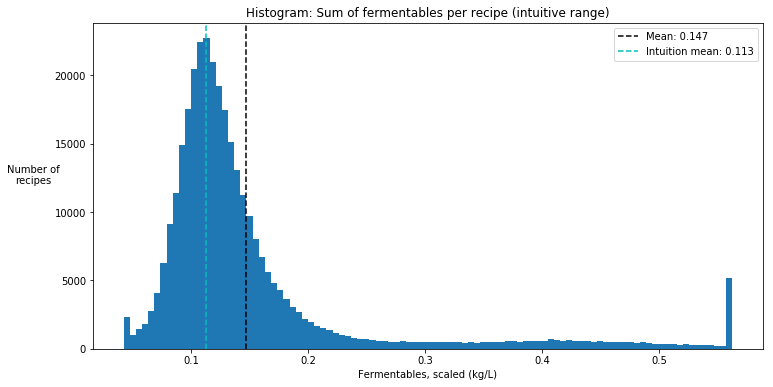

In [18]:
plt.rcParams['figure.figsize'] = [12, 6]
# Use our intuitive bounds to make a histogram
ferm_scaled = scaled_totals.ferm_scaled.dropna()
bins = np.linspace(ferm_range_scaled[0], ferm_range_scaled[2], 100)
# Use both underflow and overflow bins
plt.hist(np.clip(ferm_scaled, bins[0], bins[-1]), bins=bins);

plt.axvline(ferm_scaled.mean(), color='k', linestyle='dashed', label='Mean: {}'.format(round(ferm_scaled.mean(), 3)))
plt.axvline(ferm_range_scaled[1], color='c', linestyle='dashed', 
            label='Intuition mean: {}'.format(round(ferm_range_scaled[1], 3)))

plt.title('Histogram: Sum of fermentables per recipe (intuitive range)')
plt.xlabel('Fermentables, scaled (kg/L)')
plt.ylabel('Number of\nrecipes', rotation=0, labelpad=21)
plt.legend();

**COOL**. It looks like most recipes generally fall within my intuition quite well!
The distribution looks like a gaussian with a very long tail. I love how my guess identified the centre of the distribution super well. It's only different than the mean because of the tail. 

Things to investigate in this: 
* What's going on with the hump between 0.3 and 0.5? Are these imperial recipes?
* How many recipes don't fall within our intuitive range? 
    * Why are they falling outside?

In [183]:
ferm_within_intuition = ferm_scaled[(min(ferm_range_scaled)<=ferm_scaled)&
                                          (ferm_scaled<=max(ferm_range_scaled))]
ferm_within_intuition.count()/ferm_scaled.count()

0.9801987980216936

Not bad. So 98% of recipes make sense. Are the others worth saving?

How many are above and below?

In [184]:
ferm_above_intuition = ferm_scaled[ferm_scaled>=max(ferm_range_scaled)]
ferm_above_intuition.count()/ferm_scaled.count()

0.014931013216924435

In [185]:
ferm_below_intuition = ferm_scaled[ferm_scaled<=min(ferm_range_scaled)]
ferm_below_intuition.count()/ferm_scaled.count()

0.0048701887613819125

So there's more above our intuition. If we have to try to fix either, it should be the **high end**. 

<a id='malt_dist_ext'></a>
### Malt additions: the extremes of the range
#### Low range

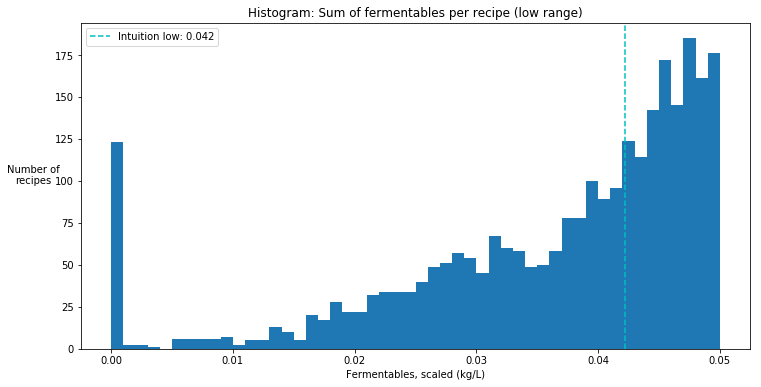

In [148]:
# Inspect the low range
# No need for an underflow bin. 0 is God's underflow bin.
plt.hist(ferm_scaled, range=[0, 0.05], bins=50);
plt.axvline(ferm_range_scaled[0], color='c', linestyle='dashed', 
            label='Intuition low: {}'.format(round(ferm_range_scaled[0], 3)))
plt.title('Histogram: Sum of fermentables per recipe (low range)')
plt.xlabel('Fermentables, scaled (kg/L)')
plt.ylabel('Number of\nrecipes', rotation=0, labelpad=21)
plt.legend();

It looks like there's two things going on here:
* A second distribution centred about 0.03 or so. 
  * I don't think these are a unit mistake.
  * We can check out recipes between 0.01 and 0.03 to get a feel for why. Is it a style thing?
* A bunch of very low outliers. Like 125. 
  * We can check these out to see if there's an easy fix. 
  * I'm cool with rejecting them.

**TODO**: Check out the style of recipes with ferm_scaled 0.01 to 0.03. Keep if there's a reasonable explanation (low-grav beer)

#### High range

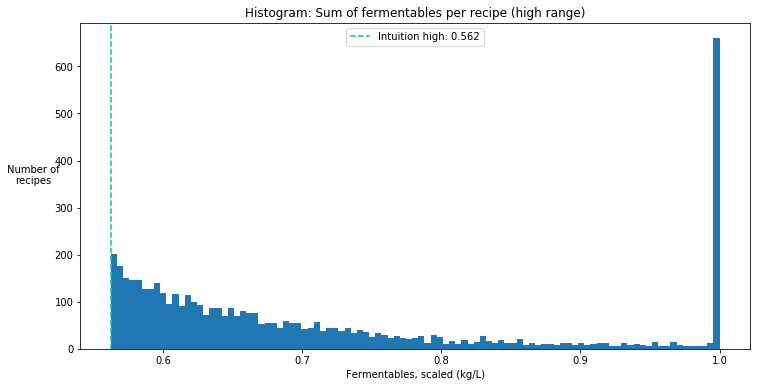

In [186]:
# Inspect the high range
bins = np.linspace(ferm_range_scaled[2], 1, 100)
# Use an overflow bin.
plt.hist(np.clip(ferm_scaled, None, bins[-1]), bins=bins);

plt.axvline(ferm_range_scaled[2], color='c', linestyle='dashed', 
            label='Intuition high: {}'.format(round(ferm_range_scaled[2], 3)))
plt.title('Histogram: Sum of fermentables per recipe (high range)')
plt.xlabel('Fermentables, scaled (kg/L)')
plt.ylabel('Number of\nrecipes', rotation=0, labelpad=21)
plt.legend();

This is actually a pretty reasonable tail from my intuition. Except for the overflow.
Let's see how far we need to identify it. 

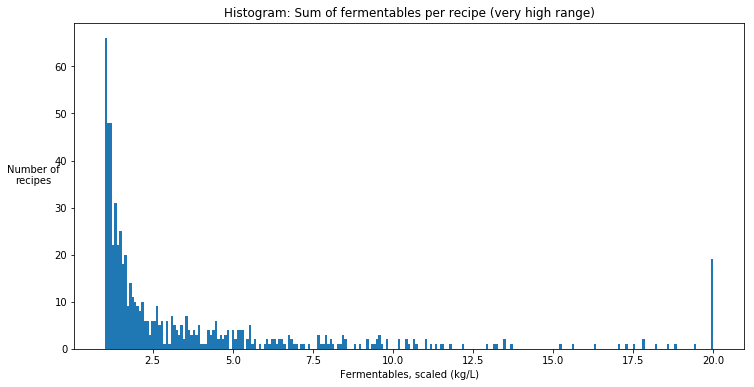

In [187]:
# Inspect the very high range
bins = np.linspace(1, 20, 250)
# Use an overflow bin.
plt.hist(np.clip(ferm_scaled, None, bins[-1]), bins=bins);
plt.title('Histogram: Sum of fermentables per recipe (very high range)')
plt.xlabel('Fermentables, scaled (kg/L)')
plt.ylabel('Number of\nrecipes', rotation=0, labelpad=21);

Alright. So we're seeing a very low tail, with a handful of crazy outliers throwing off the whole thing. 

I say get rid of the whole tail: 
  * Reject above 2.0 or so 
  * Inspect the 20 or so recipes above 20 out of morbid curiosity to see if it's a unit mistake. 

**TODO**: Inspect the 20 or so recipes to see if there's a unit mistake.

In [110]:
# Let's inspect some extreme recipes.
extreme_ferm_bounds = [2, 15]
extreme_ferm_recipes = ferm_scaled[ferm_scaled.between(*extreme_ferm_bounds)]

cols_inspect = ['ferm_amount',
   'ferm_display_amount',
   'ferm_name',
   'ferm_origin',
   'ferm_scaled',
   'ferm_yield',
   'hop_alpha',
   'hop_amount',
   'hop_display_amount',
   'hop_form',
   'hop_name',
   'hop_scaled',
   'hop_time']

recipe = extreme_ferm_recipes.sample(1).index
recipe_ing = store.select("/ingredients", where=f"index=={recipe.values[0]}")
print(ferm_scaled.loc[recipe])
print(core.loc[recipe])
print(recipe_ing[cols_inspect])

id
213875    4.405469
Name: ferm_scaled, dtype: float64
        batch_size  boil_size  boil_time       brewer  efficiency      name  \
id                                                                            
213875  946.352945  27.254965       60.0  long ranger        0.75  wit beer   

                        recipe_file style_category style_guide style_name  \
id                                                                          
213875  recipes/wit-beer-021ac0.xml            16a        bjcp    witbier   

        style_version  
id                     
213875            1.0  
        ferm_amount ferm_display_amount                 ferm_name ferm_origin  \
id                                                                              
213875   103.101546            227.3 lb                   pilsner          us   
213875    61.869999            136.4 lb               white wheat          us   
213875    20.638453             45.5 lb                     wheat          us 

#### Interesting secondary hump

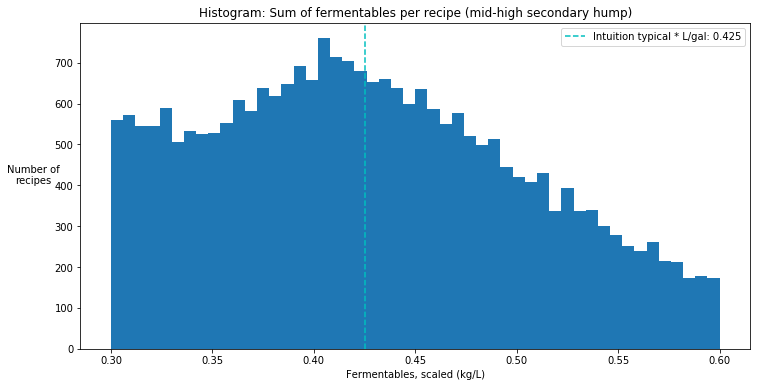

In [19]:
# Inspect the mid range
plt.hist(ferm_scaled, range=[0.3, 0.6], bins=50);
plt.axvline(ferm_range_scaled[1]*3.78, color='c', linestyle='dashed', 
            label='Intuition typical * L/gal: {}'.format(round(ferm_range_scaled[1]*3.78, 3)))
plt.title('Histogram: Sum of fermentables per recipe (mid-high secondary hump)')
plt.xlabel('Fermentables, scaled (kg/L)')
plt.ylabel('Number of\nrecipes', rotation=0, labelpad=21)
plt.legend();

What's going on with these recipes at 0.42? This is about **3.8x** my intuitive mean (0.113).
Does this line up with any possible unit mistakes?:
* lb/kg: 0.45
* oz/kg: 0.028
* g/kg: 0.001
* L/gal: **3.78**

Maybe it's a L/gal conversion error. Writing volumes in gal, not L, would cause the value to be 3.8x too high. 

Let's inspect some recipes.

In [232]:
ferm_hump_ind = ferm_scaled[ferm_scaled.between(0.40, 0.42)].index

**TODO**: Inspect the recipes in the hump to see if there's a L/gal conversion mistake going on, or just very strong beer. 

<a id='hop_dist'></a>
## Distribution of hop additions

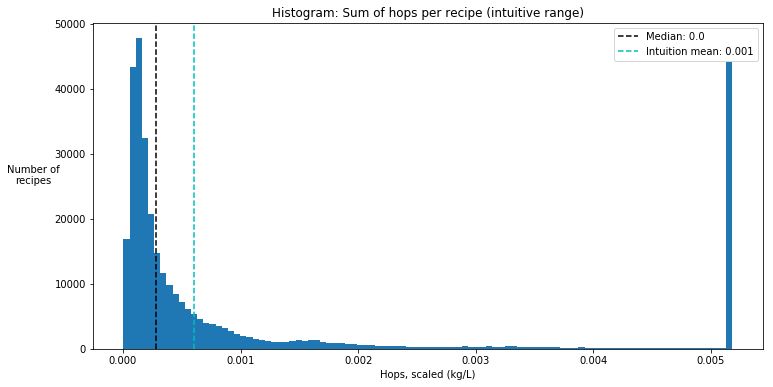

In [22]:
# Use our intuitive bounds to make a histogram
hop_scaled = scaled_totals.hop_scaled.dropna()
bins = np.linspace(hop_range_scaled[0], hop_range_scaled[2], 100)
# Use both underflow and overflow bins
plt.hist(np.clip(hop_scaled, bins[0], bins[-1]), bins=bins);

plt.axvline(hop_scaled.median(), color='k', linestyle='dashed', label='Median: {}'.format(round(hop_scaled.median(), 3)))
plt.axvline(hop_range_scaled[1], color='c', linestyle='dashed', 
            label='Intuition mean: {}'.format(round(hop_range_scaled[1], 3)))

plt.title('Histogram: Sum of hops per recipe (intuitive range)')
plt.xlabel('Hops, scaled (kg/L)')
plt.ylabel('Number of\nrecipes', rotation=0, labelpad=21)
plt.legend();

Intuition didn't serve us as well here. 

Things to investigate: 
* What's going on with the very big overflow hump? We definitely have to deal with that. 
* There's another secondary bump in the middle! Between 0.0014 and 0.0017 or so.
* The low end looks ok. Let's check it out just to be sure.

In [224]:
hop_within_intuition = hop_scaled[(min(hop_range_scaled)<=hop_scaled)&
                                          (hop_scaled<=max(hop_range_scaled))]
hop_within_intuition.count()/hop_scaled.count()

0.8561616503621655

That's not as good as our 98% for ferm. Which end do we have to deal with?

In [225]:
hop_above_intuition = hop_scaled[hop_scaled>=max(hop_range_scaled)]
hop_above_intuition.count()/hop_scaled.count()

0.13321220842352202

In [226]:
hop_below_intuition = hop_scaled[hop_scaled<=min(hop_range_scaled)]
hop_below_intuition.count()/hop_scaled.count()

0.01062614121431249

It's the **high end** we need to worry about.

**TODO**: Inspect the high end of the distribution. 
**TODO**: Inspect the middle secondary bump of the distribution. 

<a id='hop_dist_ext'></a>
### Hop additions: the extremes of the range

#### High range

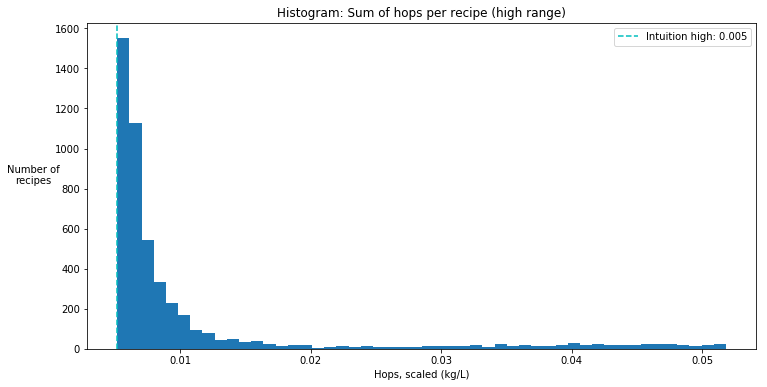

In [42]:
# Inspect the high range
# No overflow bins.
plt.hist(hop_scaled, range=[1*hop_range_scaled[2], 10*hop_range_scaled[2]], bins=50)

plt.axvline(hop_range_scaled[2], color='c', linestyle='dashed', 
            label='Intuition high: {}'.format(round(hop_range_scaled[2], 3)))
plt.title('Histogram: Sum of hops per recipe (high range)')
plt.xlabel('Hops, scaled (kg/L)')
plt.ylabel('Number of\nrecipes', rotation=0, labelpad=21)
plt.legend();

In [157]:
# Let's inspect some extreme recipes.
# extreme_hop_bounds = [0.04, 0.05]
extreme_hop_bounds = [0.005, 0.01]
extreme_hop_recipes = hop_scaled[hop_scaled.between(*extreme_hop_bounds)]

In [158]:
cols_inspect = ['ferm_amount',
   'ferm_display_amount',
   'ferm_name',
   'ferm_origin',
   'ferm_scaled',
   'ferm_yield',
   'hop_alpha',
   'hop_amount',
   'hop_display_amount',
   'hop_form',
   'hop_name',
   'hop_scaled',
   'hop_time']

In [161]:
recipe = extreme_hop_recipes.sample(1).index
recipe_ing = store.select("/ingredients", where=f"index=={recipe.values[0]}")
print(core.loc[recipe])
print(recipe_ing[cols_inspect])

       batch_size  boil_size  boil_time    brewer  efficiency   name  \
id                                                                     
99327   22.712471  29.526212       90.0  tubabrew        0.75  pliny   

                recipe_file style_category style_guide    style_name  \
id                                                                     
99327  recipes/pliny-37.xml            14c        bjcp  imperial ipa   

       style_version  
id                    
99327            1.0  
       ferm_amount ferm_display_amount                 ferm_name ferm_origin  \
id                                                                             
99327     6.010099            13.25 lb                     2-row          us   
99327     0.340194             0.75 lb     dextrose (corn sugar)         NaN   
99327     0.283495            0.625 lb  carapils (dextrine malt)          us   
99327     0.283495            0.625 lb               crystal 45l          uk   
99327     0.22679

Aha! The hop_display amount shows us that the unit is in fact wrong.
We're expecting kg. It's giving us g.

<a id="ing_units"></a>
# Ingredient units
What units are the ingredients in? 

Let's check:
* If we'll always have display_amount units available to calibrate our ferm_amount and hop_amount.
* What those units are

## Ferm

In [116]:
ferm_amts = store.select("/ingredients", columns=['ferm_amount', 'ferm_display_amount'])

In [126]:
# Get the display amounts for additions where the amount itself is defined
ferm_amts = ferm_amts.dropna(subset=['ferm_amount'])['ferm_display_amount']

In [136]:
# Get the units: they're the last part of the display amount, separated by space
ferm_units = ferm_amts.apply(lambda x: x.split(' ')[-1])

In [137]:
# What units are there and how often do they show up?
ferm_units.value_counts()

lb    1282449
kg     157997
Name: ferm_display_amount, dtype: int64

In [142]:
# Do these categories account for every recipe?
ferm_units.value_counts().sum() == ferm_amts.count()

True

## Hop

In [162]:
hop_amts = store.select("/ingredients", columns=['hop_amount', 'hop_display_amount'])

In [163]:
# Get the display amounts for additions where the amount itself is defined
hop_amts = hop_amts.dropna(subset=['hop_amount'])['hop_display_amount']

In [149]:
# Get the units: they're the last part of the display amount, separated by space
hop_units = hop_amts.apply(lambda x: x.split(' ')[-1])

In [151]:
# What units are there and how often do they show up?
hop_units.value_counts()

oz    1120248
g      162956
Name: hop_display_amount, dtype: int64

In [152]:
# Do these categories account for every recipe?
hop_units.value_counts().sum() == hop_units.count()

True

<a id='weird'></a>
# Deep dive: weird recipes

What recipes have extreme values? Should we reject some off hand?

In [24]:
hops = store.select("/ingredients",columns=["hop_alpha", "hop_amount"])

In [25]:
hops["hop_alpha"].median()

0.087

In [26]:
hops["hop_amount"].describe()

count    1.283204e+06
mean     9.213688e+00
std      5.777160e+02
min      0.000000e+00
25%      1.417477e-02
50%      2.834950e-02
75%      4.961162e-02
max      5.312500e+05
Name: hop_amount, dtype: float64

A median of 30g per hop addition is reasonable, especially given that we're dominated by IPAs. Since our median boil size is 24 L, not 20, and our median alpha is 0.09, not 0.05, we're now in the right ballpark.

So, what about our exreme values?

In [38]:
scaled_totals.loc[scaled_totals["ferm_scaled"].argmax()]

/home/rory/Preteckt/utils/gm-repo/preteckt_gm/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


ferm_scaled    902.521788
hop_scaled       0.002501
Name: 226295, dtype: float64

In [39]:
core.loc[226295]

batch_size                                19
boil_size                              6.024
boil_time                                 60
brewer                                  세환 임
efficiency                              0.65
name                             zombie dust
recipe_file       recipes/zombie-dust-31.xml
style_category                           14b
style_guide                             bjcp
style_name                      american ipa
style_version                              1
vol_ratio                            3.15405
Name: 226295, dtype: object

In [40]:
r = store.select("/ingredients", where="index==226295")
print(r)

        amount  attenuation  color  ferm_amount ferm_display_amount  \
id                                                                    
226295     NaN         70.0   25.0  5848.393223          12893.5 lb   
226295     NaN          NaN    1.0  4816.334503          10618.2 lb   
226295     NaN          NaN    1.0    64.546194            142.3 lb   
226295     NaN          NaN    NaN          NaN                 NaN   
226295     NaN          NaN    NaN          NaN                 NaN   

         ferm_name ferm_origin  ferm_scaled  ferm_yield  flocculation  \
id                                                                      
226295  melanoidin          de   504.187300    0.798964           NaN   
226295    carapils          de   392.769991    0.755776           NaN   
226295       2-row          us     5.564498    0.798964           NaN   
226295         NaN         NaN          NaN         NaN           NaN   
226295         NaN         NaN          NaN         NaN         

This recipe just looks messed up. Let's just drop it. We'll keep a tally of recipes we want to drop...

In [41]:
bad_recipes = []

In [42]:
bad_recipes.append(226295)

In [45]:
scaled_totals = scaled_totals.drop(226295)

In [46]:
scaled_totals.loc[scaled_totals["ferm_scaled"].argmax()]

/home/rory/Preteckt/utils/gm-repo/preteckt_gm/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


ferm_scaled    162.378940
hop_scaled       0.524386
Name: 206827, dtype: float64

In [49]:
print(core.loc[206827])
r = store.select("/ingredients", where="index==206827")
print(r)

batch_size                                    23352.2
boil_size                                      27.255
boil_time                                          60
brewer                                       the jeep
efficiency                                       0.82
name                       1904 india pale ale (org.)
recipe_file       recipes/1904-india-pale-ale-org.xml
style_category                                    19a
style_guide                                      bjcp
style_name                                    old ale
style_version                                       1
vol_ratio                                     856.806
Name: 206827, dtype: object
        amount  attenuation  color  ferm_amount ferm_display_amount  \
id                                                                    
206827     NaN         66.0    1.0  3855.535145           8500.0 lb   
206827     NaN          NaN    1.0  1587.573295           3500.0 lb   
206827     NaN          NaN    0.0  1520

In [50]:
core[core.brewer == "the jeep"]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version,vol_ratio
id,,,,,,,,,,,,
14908,37.854118,27.254965,60.0,the jeep,0.82,1904 india pale stock (scaled),recipes/1904-india-pale-stock-scaled.xml,19a,bjcp,old ale,1.0,1.388889
46982,22296.075384,27.254965,60.0,the jeep,0.80,1901 xxx stock ale (original),recipes/1901-xxx-stock-ale-original.xml,19a,bjcp,old ale,1.0,818.055556
74569,37.854118,27.254965,90.0,the jeep,0.75,1904 diamond stock ale (scaled/adjusted),recipes/1904-diamond-stock-ale-scaled-adjusted...,19a,bjcp,old ale,1.0,1.388889
95628,23821.596332,27.254965,45.0,the jeep,0.65,1901 winter stock (org.),recipes/1901-winter-stock-org.xml,19a,bjcp,old ale,1.0,874.027778
129923,37.854118,27.254965,90.0,the jeep,0.75,1835 aa adapted,recipes/1835-aa-adapted.xml,10a,bjcp,american pale ale,1.0,1.388889
137662,9.804217,14.043878,90.0,the jeep,0.80,marley's ghost - 1843 christmas porter,recipes/marleys-ghost-1843-christmas-port.xml,23a,bjcp,specialty beer,1.0,0.698113
168580,15255.209473,27.254965,85.0,the jeep,0.75,war beer 1918,recipes/war-beer-1918.xml,10a,bjcp,american pale ale,1.0,559.722222
191577,23469.553036,27.254965,90.0,the jeep,0.83,1904 diamond stock (org.),recipes/1904-diamond-stock-org.xml,19a,bjcp,old ale,1.0,861.111111
204945,20.819765,24.983718,60.0,the jeep,0.75,albany ale 1650,recipes/albany-ale-1650.xml,23a,bjcp,specialty beer,1.0,0.833333


So this case looks like someone who consistently entered the wrong units for their recipes. Our best guess is that he entered batch sizes in ml. When looking up some of the recpes listed above online, they're all given in lbs - these look like they're off by a factor of 1000. Not sure why he would have entered boil size in L though... maybe it was auto-calculated. In any case, it looks like we'll need to fix these. They also look like very interesting old-timey recipes!

It seems like we can speed things up a bit by looking for all recipes with a bad vol_ratio...

In [54]:
print(core[core.vol_ratio > 100])

          batch_size  boil_size  boil_time                 brewer  efficiency  \
id                                                                              
4813     3000.000000  27.252000       90.0                  eross        0.75   
26235       5.980951   0.034069       60.0  felipe rooke da silva        0.75   
38091     550.000000   1.000000       90.0                  hetyu        0.70   
46982   22296.075384  27.254965       60.0               the jeep        0.80   
95628   23821.596332  27.254965       45.0               the jeep        0.65   
95887    6000.000000  51.102000       60.0                  eross        0.75   
96055    5163.301668  27.254965       60.0                 travis        0.75   
101954   3600.000000  29.700000       60.0       matthew stephens        0.62   
102464   5000.000000  27.000000       60.0      two chefs brewing        0.90   
152698   4000.000000  27.252000       60.0                  eross        0.90   
168580  15255.209473  27.254

In [53]:
bad_recipes.append(38091)
bad_recipes.append(227992)

In [55]:
core[core.brewer == "eross"]

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,style_version,vol_ratio
id,,,,,,,,,,,,
4813,3000.000000,27.252000,90.0,eross,0.75,bsbc pls,recipes/bsbc-pls.xml,2b,bjcp,bohemian pilsener,1.0,110.083664
7165,4000.000000,1084.210000,60.0,eross,0.90,bsbc porter,recipes/bsbc-porter.xml,12a,bjcp,brown porter,1.0,3.689322
32308,49.210353,27.254965,60.0,eross,0.75,kcc,recipes/kcc-c5233a.xml,6a,bjcp,cream ale,1.0,1.805556
32969,4000.000000,1058.290000,60.0,eross,0.90,marz,recipes/marz-3.xml,3b,bjcp,oktoberfest/märzen,1.0,3.779682
95887,6000.000000,51.102000,60.0,eross,0.75,bsbc,recipes/bsbc-9e9d6d.xml,5a,bjcp,maibock/helles bock,1.0,117.412234
119940,4000.000000,1133.110000,60.0,eross,0.90,esb,recipes/esb-460.xml,8c,bjcp,extra special/strong bitter (english pale ale),1.0,3.530107
152698,4000.000000,27.252000,60.0,eross,0.90,double vision,recipes/double-vision-3.xml,14b,bjcp,american ipa,1.0,146.778218
181014,37.854118,41.639530,60.0,eross,0.75,hey! porter,recipes/hey-porter-12.xml,12b,bjcp,robust porter,1.0,0.909091
241600,56.781177,68.137412,60.0,eross,0.75,electric lager,recipes/electric-lager.xml,1c,bjcp,premium american lager,1.0,0.833333


In [61]:
inds = core[core.brewer == "eross"].index
r = core.join(store.select("/ingredients", where=f"index in {list(inds)}"),how="inner")
#for recipe_id,group in r.groupby(r.index):
#    print(group)

In [62]:
r

,batch_size,boil_size,boil_time,brewer,efficiency,name,recipe_file,style_category,style_guide,style_name,...,misc_amount,misc_amount_is_weight,misc_name,misc_time,misc_use,potential,product_id,type,yeast_laboratory,yeast_name
id,,,,,,,,,,,,,,,,,,,,,
4813,3000.000000,27.252000,90.0,eross,0.75,bsbc pls,recipes/bsbc-pls.xml,2b,bjcp,bohemian pilsener,...,NaN,False,NaN,NaN,NaN,1.037,NaN,lager,fermentis,saflager s-23
4813,3000.000000,27.252000,90.0,eross,0.75,bsbc pls,recipes/bsbc-pls.xml,2b,bjcp,bohemian pilsener,...,NaN,False,NaN,NaN,NaN,1.035,NaN,NaN,NaN,NaN
4813,3000.000000,27.252000,90.0,eross,0.75,bsbc pls,recipes/bsbc-pls.xml,2b,bjcp,bohemian pilsener,...,NaN,False,NaN,NaN,NaN,1.033,NaN,NaN,NaN,NaN
7165,4000.000000,1084.210000,60.0,eross,0.90,bsbc porter,recipes/bsbc-porter.xml,12a,bjcp,brown porter,...,NaN,False,NaN,NaN,NaN,1.037,NaN,ale,fermentis,safale us-05
7165,4000.000000,1084.210000,60.0,eross,0.90,bsbc porter,recipes/bsbc-porter.xml,12a,bjcp,brown porter,...,NaN,False,NaN,NaN,NaN,1.037,NaN,NaN,NaN,NaN
7165,4000.000000,1084.210000,60.0,eross,0.90,bsbc porter,recipes/bsbc-porter.xml,12a,bjcp,brown porter,...,NaN,False,NaN,NaN,NaN,1.029,NaN,NaN,NaN,NaN
7165,4000.000000,1084.210000,60.0,eross,0.90,bsbc porter,recipes/bsbc-porter.xml,12a,bjcp,brown porter,...,NaN,False,NaN,NaN,NaN,1.032,NaN,NaN,NaN,NaN
32308,49.210353,27.254965,60.0,eross,0.75,kcc,recipes/kcc-c5233a.xml,6a,bjcp,cream ale,...,NaN,False,NaN,NaN,NaN,1.035,NaN,ale,fermentis,safale us-05
32308,49.210353,27.254965,60.0,eross,0.75,kcc,recipes/kcc-c5233a.xml,6a,bjcp,cream ale,...,NaN,False,NaN,NaN,NaN,1.040,NaN,NaN,NaN,NaN
